# Hackathon SUS 2025

## 1. Imports and Configuration

In [1]:
# ───────────────────────────────────────────────────────────────
# Standard library
# ───────────────────────────────────────────────────────────────
import math
import os
import random
import warnings
from functools import partial
from pathlib import Path

# ───────────────────────────────────────────────────────────────
# Third-party scientific stack
# ───────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

# ───────────────────────────────────────────────────────────────
# Scikit-learn core
# ───────────────────────────────────────────────────────────────
from sklearn import set_config
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    make_scorer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    ParameterSampler
)
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression

# ───────────────────────────────────────────────────────────────
# Statsmodels
# ───────────────────────────────────────────────────────────────
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial

# ───────────────────────────────────────────────────────────────
# Gradient-boosting frameworks
# ───────────────────────────────────────────────────────────────
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM

# ───────────────────────────────────────────────────────────────
# Deep-learning frameworks
# ───────────────────────────────────────────────────────────────
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.utils import class_weight

# ───────────────────────────────────────────────────────────────
# Library-wide config
# ───────────────────────────────────────────────────────────────
set_config(transform_output="pandas")
sns.set_style("whitegrid")

In [2]:
# Experiment Cofiguration
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        torch.manual_seed(seed)
        tf.random.set_seed(seed)
    except Exception:
        pass

set_seed()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
print('Seed set! ✅')

Seed set! ✅


In [3]:
# Constants
THR  = 0.50
SEED = 42

## 2. Data Loading

In [4]:
DATA_PATH = Path.cwd() / 'Datasets'
train_df = pd.read_csv(DATA_PATH / 'train.csv', sep = ' ')
test_df  = pd.read_csv(DATA_PATH / 'test.csv', sep = ' ')

print(train_df.shape, test_df.shape)

(55307, 9) (23743, 8)


In [5]:
train_df.columns = [
    'is_laundering',
    'from_account',
    'to_account',
    'payment_type',
    'amount_paid',
    'type_account_from',
    'type_account_to',
    'avg_stock_account_from',
    'avg_stock_account_to'
]

test_df.columns = [
    'from_account',
    'to_account',
    'payment_type',
    'amount_paid',
    'type_account_from',
    'type_account_to',
    'avg_stock_account_from',
    'avg_stock_account_to'
]

TARGET = 'is_laundering'

## 3. Quick Exploratory Data Analysis

In [6]:
train_df.head()

,is_laundering,from_account,to_account,payment_type,amount_paid,type_account_from,type_account_to,avg_stock_account_from,avg_stock_account_to
0,1,U0551,U2203,Cheque,186509.285,B,B,3.085334e+08,1144577.897
1,0,U4572,U9001,ACH,439.995,D,B,3.752614e+04,2084650.425
2,1,U0551,U2203,Cheque,186711.187,E,B,3.085329e+08,1144922.015
3,0,U1223,U7781,ACH,958.824,A,D,8.675015e+04,3313102.013
4,1,U0551,U2203,Cash,188971.312,B,B,3.085321e+08,1143957.237


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55307 entries, 0 to 55306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   is_laundering           55307 non-null  int64  
 1   from_account            55307 non-null  object 
 2   to_account              55307 non-null  object 
 3   payment_type            55307 non-null  object 
 4   amount_paid             55307 non-null  float64
 5   type_account_from       55307 non-null  object 
 6   type_account_to         55307 non-null  object 
 7   avg_stock_account_from  55307 non-null  float64
 8   avg_stock_account_to    55307 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 3.8+ MB


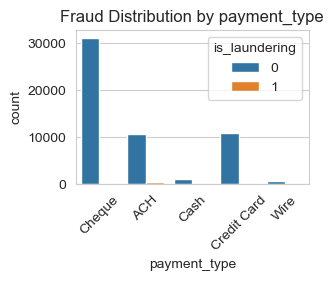

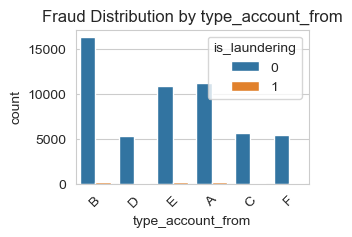

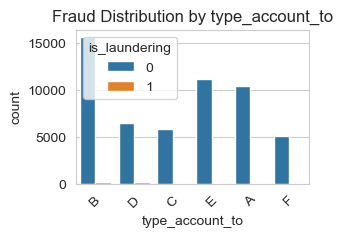

In [8]:
cat_cols = ["payment_type", "type_account_from", "type_account_to"]

for col in cat_cols:
    plt.figure(figsize=(3, 2))
    sns.countplot(data=train_df, x=col, hue="is_laundering")
    plt.title(f'Fraud Distribution by {col}')
    plt.xticks(rotation=45)
    plt.show()

<Axes: xlabel='payment_type', ylabel='Count'>

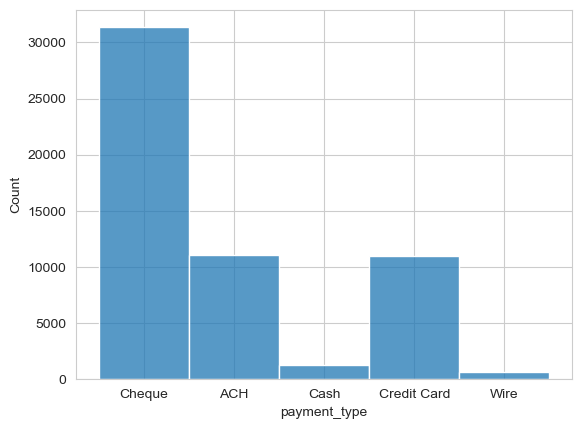

In [9]:
sns.histplot(train_df['payment_type'])

<Axes: xlabel='type_account_from', ylabel='Count'>

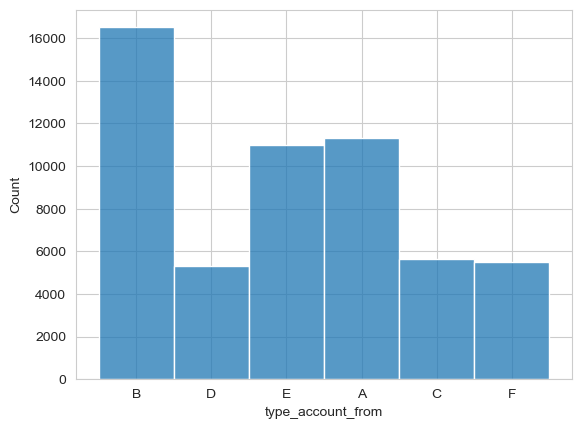

In [10]:
sns.histplot(train_df['type_account_from'])

In [11]:
train_df['from_account'].nunique()

16998

In [12]:
proportions_payment_type = (
    train_df.groupby('payment_type')['is_laundering']
    .mean()
    .multiply(100)
    .round(2)
    .reset_index()
    .rename(columns={'is_laundering': 'laundering_percent'})
)

display(proportions_payment_type)

,payment_type,laundering_percent
0,ACH,3.66
1,Cash,1.38
2,Cheque,0.58
3,Credit Card,0.67
4,Wire,1.27


In [13]:
proportions_type_account_from = (
    train_df.groupby('type_account_from')['is_laundering']
    .mean()
    .multiply(100)
    .round(2)
    .reset_index()
    .rename(columns={'is_laundering': 'laundering_percent'})
)
display(proportions_type_account_from)

,type_account_from,laundering_percent
0,A,1.21
1,B,1.29
2,C,1.08
3,D,1.39
4,E,1.28
5,F,1.09


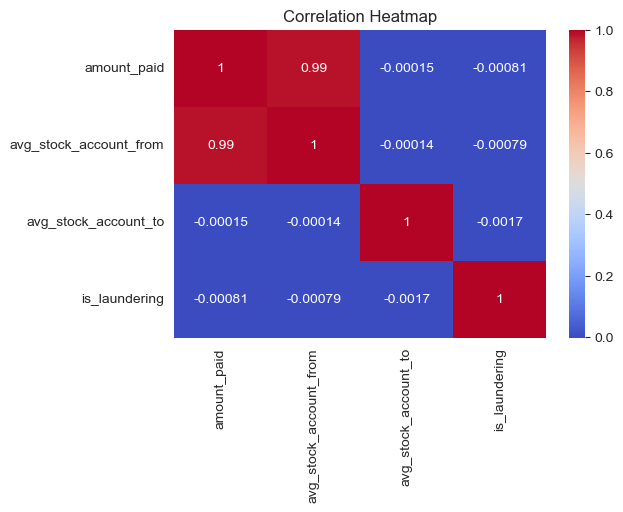

In [14]:
num_cols = ["amount_paid", "avg_stock_account_from", "avg_stock_account_to"]

plt.figure(figsize=(6, 4))
sns.heatmap(train_df[num_cols + ["is_laundering"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 4. Score Function

In [15]:
def composite_metric(
    y_true,
    y_proba,
    *,
    top_n: int = 485,
    thr: float = 0.50,
) -> float:
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]

    auc = roc_auc_score(y_true, y_proba)
    y_pred = (y_proba >= thr).astype(int)
    ba = balanced_accuracy_score(y_true, y_pred)

    n = min(top_n, len(y_true))
    top_idx = np.argpartition(-y_proba, n - 1)[:n]
    fcr = y_true[top_idx].sum() / y_true.sum() if y_true.sum() else 0.0

    return (auc + ba + fcr) / 3


composite_scorer = make_scorer(composite_metric, needs_proba=True)

In [16]:
def get_cv(n_splits: int = 5, stratify: bool = True, random_state: int = 42):
    if stratify:
        return StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=random_state,
        )
    return KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [17]:
def evaluate_model(
    model,
    X,
    y,
    *,
    stratify: bool = True,
    top_n: int = 485,
):
    scorer = make_scorer(composite_metric, needs_proba=True, top_n=top_n)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=get_cv(stratify=stratify),
        scoring=scorer,
        n_jobs=-1,
    )

    if hasattr(model, 'steps'):  # если это pipeline
        model_name = model.steps[-1][1].__class__.__name__
    else:
        model_name = model.__class__.__name__

    print(
        f"{model_name} composite score: {scores.mean():.4f} ± {scores.std():.4f}"
    )
    return scores


## 5. Preprocessing & Feature Engineering

In [18]:
def feature_engineering(df):
    df = df.copy()

    df['log_amount'] = np.log1p(df['amount_paid'])

    df['multiple_sends'] = df.groupby(['from_account', 'to_account'])['to_account'].transform('count') > 1

    df['sender_tx_count'] = df['from_account'].map(df['from_account'].value_counts())
    df['receiver_tx_count'] = df['to_account'].map(df['to_account'].value_counts())

    df['sender_unique_receivers'] = df.groupby('from_account')['to_account'].transform('nunique')
    df['receiver_unique_senders'] = df.groupby('to_account')['from_account'].transform('nunique')

    df['is_internal'] = (df['type_account_from'] == df['type_account_to']).astype(int)

    df['stock_diff'] = df['avg_stock_account_from'] - df['avg_stock_account_to']
    df['stock_ratio'] = df['avg_stock_account_from'] / (df['avg_stock_account_to'] + 1e-6)

    return df.fillna(0)

In [19]:
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

features = [
    'log_amount',
    'multiple_sends',
    'sender_tx_count',
    'receiver_tx_count',
    'sender_unique_receivers',
    'receiver_unique_senders',
    'is_internal',
    'stock_diff',
    'stock_ratio',
    'payment_type',
    'type_account_from',
    'type_account_to'
]

X = train_df[features]
y = train_df['is_laundering'].values

X_test = test_df[features].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Preprocessing complete")
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

✅ Preprocessing complete
Train set shape: (44245, 12)
Validation set shape: (11062, 12)
Test set shape: (23743, 12)


## 6. Logistic Regression

### Logistic Regression (Logit)

In [20]:
test_df.head()

,from_account,to_account,payment_type,amount_paid,type_account_from,type_account_to,avg_stock_account_from,avg_stock_account_to,log_amount,multiple_sends,sender_tx_count,receiver_tx_count,sender_unique_receivers,receiver_unique_senders,is_internal,stock_diff,stock_ratio
0,U7751,U9254,Cheque,1097.343,C,B,9637.145,2893306.800,7.001558,False,1,1,1,1,0,-2883669.655,0.003331
1,U7875,U9283,Credit Card,468.615,F,B,6791.753,4302009.020,6.151913,False,1,1,1,1,0,-4295217.267,0.001579
2,U8381,U8381,ACH,0.680,B,B,275.427,1673.652,0.518794,False,2,1,2,1,1,-1398.225,0.164566
3,U8381,U9252,ACH,0.490,B,F,303.842,4006937.880,0.398776,False,2,1,2,1,0,-4006634.038,0.000076
4,U6437,U5898,ACH,360651.143,B,A,2528530.067,3064574.755,12.795669,True,4,4,1,1,0,-536044.688,0.825084


In [21]:
categorical_features = ['payment_type', 'type_account_from', 'type_account_to']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
])

In [22]:
baseline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            LogisticRegression(),
        ),
    ]
)

In [23]:
_ = evaluate_model(baseline, X_train, y_train, stratify=True, top_n=485)

LogisticRegression composite score: 0.4799 ± 0.0123


### Logistic Regression (Logit)

In [24]:
X_enc = pd.get_dummies(X_train, drop_first=True).astype(float)
X_enc = sm.add_constant(X_enc, has_constant="add")

model = sm.GLM(y_train, X_enc, family=Binomial(link=sm.families.links.probit()))
result = model.fit()

X_val_enc = pd.get_dummies(X_val, drop_first=True).astype(float)
X_val_enc = sm.add_constant(X_val_enc, has_constant="add")

y_val_proba = result.predict(X_val_enc)

composite_metric_score = composite_metric(y_val, y_val_proba, top_n=485)
print(f"Composite metric on val: {composite_metric_score:.4f}")

Composite metric on val: 1.0000


### Logistic Regression (GridSearch)

In [25]:
# param_grid = [
#     {
#         "model__solver": ["liblinear"],
#         "model__penalty": ["l1", "l2"],
#         "model__C": [0.01, 0.1, 1, 10, 100],
#         "model__class_weight": [
#             None,
#             "balanced",
#             {0: 1, 1: 2},
#             {0: 1, 1: 5},
#         ],
#     },
#     {
#         "model__solver": ["lbfgs"],
#         "model__penalty": ["l2"],
#         "model__C": [0.01, 0.1, 1, 10, 100],
#         "model__class_weight": [None, "balanced"],
#     },
#     {
#         "model__solver": ["saga"],
#         "model__penalty": ["l1", "l2"],
#         "model__C": [0.01, 0.1, 1, 10],
#         "model__class_weight": [None, "balanced"],
#     },
# ]

# search = GridSearchCV(
#     estimator=baseline,
#     param_grid=param_grid,
#     scoring=composite_scorer,
#     cv=get_cv(stratify=True),
#     n_jobs=-1,
#     verbose=2,
#     refit=True,
# )

# search.fit(X, y)

# print("Best composite score: ", search.best_score_)
# print("Best hyperparameters: ", search.best_params_)

# best_model = search.best_estimator_

## 7. Tree‑Based Models (RandomForest)

### RandomForest (Simple)

In [26]:
rf_model_simple = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced",
)

In [27]:
rf_model_simple.fit(X_enc, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [28]:
y_proba = rf_model_simple.predict_proba(X_val_enc)[:, 1]

score = composite_metric(
    y_true=y_val,
    y_proba=y_proba,
    top_n=485,
    thr=0.50,
)

print(f"Composite metric on validation set: {score:.4f}")

Composite metric on validation set: 1.0000


In [29]:
# y_test_pred = rf_model_simple.predict_proba(X_test)[:, 1]
# pred  = (y_test_pred >= THR).astype(int)

# submission = pd.DataFrame({
#     "prob(Fraud)": y_test_pred,
#     "prediction" : pred,
# })

# submission.to_csv(
#     "submissionrf_model_simple.txt",
#     index=False,
#     header=False,
#     sep="\t",
#     float_format="%.6f"
# )

In [30]:
#0,69408

### Random Forest (RandomizedSearchCV)

In [31]:
# rs_pipe = Pipeline(
#     steps=[
#         ("preprocess", preprocessor),
#         (
#             "model",
#             RandomForestClassifier(
#     n_estimators=400,
#     random_state=SEED,
#     n_jobs=-1,
#     class_weight="balanced",
# ),
#         ),
#     ]
# )

# param_dist = {
#     "model__max_depth":        [None] + list(range(5, 31, 5)),
#     "model__min_samples_split": randint(2, 11),
#     "model__min_samples_leaf": randint(1, 6),
#     "model__max_features":     uniform(0.3, 0.7),
# }

# rs = RandomizedSearchCV(
#         rs_pipe,
#         param_dist,
#         n_iter=40,
#         cv=3,
#         scoring=composite_scorer,
#         n_jobs=1,
#         random_state=SEED,
#         verbose=2,
# )

# rs.fit(X, y)

In [32]:
# results_df = pd.DataFrame(rs.cv_results_)
# results_df.sort_values("mean_test_score", ascending=False).head(5)

In [33]:
# best_pipe_rf_rs = rs.best_estimator_
# _ = evaluate_model(best_pipe_rf_rs, X, y, stratify=True, top_n=485)

In [34]:
# best_pipe_rf_rs = rs.best_estimator_

# proba = best_pipe_rf_rs.predict_proba(test)[:, 1]
# pred  = (proba >= THR).astype(int)

# submission = pd.DataFrame({
#     "prob(Fraud)": proba,
#     "prediction" : pred,
# })

# submission.to_csv(
#     "submission3.txt",
#     index=False,
#     header=False,
#     sep="\t",
#     float_format="%.6f"
# )

## 8. Gradient Boosting Libraries (XGBoost, LightGBM, CatBoost)

In [35]:
xgb_model = XGB(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.01,
    scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train),
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_enc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
y_proba = xgb_model.predict_proba(X_val_enc)[:, 1]

score = composite_metric(
    y_true=y_val,
    y_proba=y_proba,
    top_n=485,
    thr=0.50,
)

print(f"Composite metric on validation set: {score:.4f}")

Composite metric on validation set: 1.0000


In [37]:
# y_test_pred = xgb_model.predict_proba(X_test)[:, 1]
# pred  = (y_test_pred >= THR).astype(int)

# submission = pd.DataFrame({
#     "prob(Fraud)": y_test_pred,
#     "prediction" : pred,
# })

# submission.to_csv(
#     "submissionrf_xgb_model.txt",
#     index=False,
#     header=False,
#     sep="\t",
#     float_format="%.6f"
# )

## ExtraTreesClassifier

In [38]:
et_clf = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

In [39]:
et_clf.fit(X_enc, y_train)

ExtraTreesClassifier(max_depth=10, n_estimators=300, n_jobs=-1, random_state=42)

In [40]:
y_proba = et_clf.predict_proba(X_val_enc)[:, 1]

score = composite_metric(
    y_true=y_val,
    y_proba=y_proba,
    top_n=485,
    thr=0.50,
)

print(f"Composite metric on validation set: {score:.4f}")

Composite metric on validation set: 0.9975


## 11. Simple Neural Network (Keras)

### 11.1

In [41]:
class AMLMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, top_n=485):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.top_n = top_n
        self.best_score = -1
        self.best_weights = None
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_val, verbose=0).flatten()
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)

        auc = roc_auc_score(self.y_val, y_pred_proba)

        ba = balanced_accuracy_score(self.y_val, y_pred_binary)

        top_n_idx = np.argsort(y_pred_proba)[-self.top_n:]
        fcr = np.sum(self.y_val[top_n_idx]) / np.sum(self.y_val) if np.sum(self.y_val) > 0 else 0

        aml_score = (auc + ba + fcr) / 3
        self.history.append({'epoch': epoch + 1, 'auc': auc, 'ba': ba, 'fcr': fcr, 'aml': aml_score})

        print(f"\nEpoch {epoch+1}: AUC={auc:.4f}, BA={ba:.4f}, FCR@{self.top_n}={fcr:.4f} → AML={aml_score:.4f}")

        if aml_score > self.best_score:
            self.best_score = aml_score
            self.best_weights = self.model.get_weights()
            print("Best AML score — model weights saved.")

        if logs is not None:
            logs['aml'] = aml_score
            logs['auc'] = auc
            logs['ba'] = ba
            logs['fcr'] = fcr

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nRestored best model weights (AML={self.best_score:.4f})")

In [42]:
model = models.Sequential([
    layers.Input(shape=(X_enc.shape[1],)),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [43]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              # loss=focal_loss(gamma=2, alpha=0.25),
              # metrics=[tf.keras.metrics.AUC(name="AUC")]
              )

aml_callback = AMLMetricCallback(X_val_enc, y_val, top_n=485)

model.fit(
    X_enc, y_train,
    validation_data=(X_val_enc, y_val),
    epochs=30,
    batch_size=64,
    # class_weight=class_weights,
    callbacks=[aml_callback],
    verbose=1
)

Epoch 1/30
626/692 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 4002499.2500
Epoch 1: AUC=0.4901, BA=0.4988, FCR@485=0.0219 → AML=0.3369
Best AML score — model weights saved.
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - loss: 3710560.5000 - val_loss: 120521.6719 - aml: 0.3369 - auc: 0.4901 - ba: 0.4988 - fcr: 0.0219
Epoch 2/30
652/692 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 108363.0000
Epoch 2: AUC=0.4975, BA=0.4998, FCR@485=0.0365 → AML=0.3446
Best AML score — model weights saved.
692/692 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 108819.2500 - val_loss: 95523.9062 - aml: 0.3446 - auc: 0.4975 - ba: 0.4998 - fcr: 0.0365
Epoch 3/30
666/692 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 112337.4141
Epoch 3: AUC=0.4964, BA=0.4997, FCR@485=0.0365 → AML=0.3442
692/692 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 111924.3125 - val_loss: 76667.5000 - aml: 0.3442 - auc: 0.4964 - ba: 0.4997 - fcr: 0.0365
Epoch 4/30
661/692 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 116973.1016
Epoch 4: AUC=0.4775, B

In [45]:
y_pred_proba = model.predict(X_val_enc, verbose=0).flatten()

score = composite_metric(
    y_true=y_val,
    y_proba=y_proba,
    top_n=485,
    thr=0.50,
)

print(f"Composite metric on validation set: {score:.4f}")

Composite metric on validation set: 0.9975


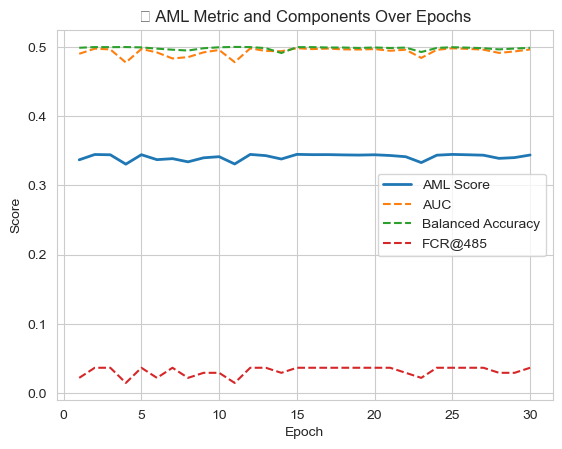

In [46]:
history = aml_callback.history
epochs = [h['epoch'] for h in history]

plt.plot(epochs, [h['aml'] for h in history], label='AML Score', linewidth=2)
plt.plot(epochs, [h['auc'] for h in history], label='AUC', linestyle='--')
plt.plot(epochs, [h['ba'] for h in history], label='Balanced Accuracy', linestyle='--')
plt.plot(epochs, [h['fcr'] for h in history], label='FCR@485', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("📈 AML Metric and Components Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

### 11.2

In [47]:
best_score = -1
best_model = None
best_params = None
results = []

# Smart hyperparameter space
param_dist = {
    'units1': [64, 128],
    'units2': [32, 64, 128],
    'dropout': uniform(0.2, 0.3),
    'lr': [1e-3, 5e-4, 1e-4]
}
param_grid = list(ParameterSampler(param_dist, n_iter=15, random_state=42))

for i, params in enumerate(param_grid):
    print(f"\n🔍 Trial {i+1}/{len(param_grid)} - Params: {params}")

    # Class weights
    cw = class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
    class_weights = {0: cw[0], 1: cw[1] * 3}

    # Build model
    model = models.Sequential([
        layers.Input(shape=(X_enc.shape[1],)),
        layers.Dense(params['units1'], activation='relu'),
        layers.Dropout(params['dropout']),
        layers.Dense(params['units2'], activation='relu'),
        layers.Dropout(params['dropout']),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']),
                  loss='binary_crossentropy')

    # AML callback
    aml_cb = AMLMetricCallback(X_val_enc, y_val, top_n=485)
    model.fit(X_enc, y_train,
              validation_data=(X_val_enc, y_val),
              epochs=15,
              batch_size=256,
              class_weight=class_weights,
              callbacks=[aml_cb],
              verbose=0)

    trial_score = aml_cb.best_score
    results.append({'trial': i+1, 'params': params, 'aml_score': trial_score})

    if trial_score > best_score:
        best_score = trial_score
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(aml_cb.best_weights)
        best_params = params

    print(f"✅ AML Score: {trial_score:.4f}")

# Sort and report all results
results_df = pd.DataFrame(results).sort_values(by='aml_score', ascending=False)
print("\n🔝 Top 5 Trials:")
print(results_df.head())

print("\n✅ Best Score:", best_score)
print("📦 Best Params:", best_params)


🔍 Trial 1/15 - Params: {'dropout': 0.3123620356542087, 'lr': 0.001, 'units1': 64, 'units2': 128}

Epoch 1: AUC=0.4986, BA=0.5000, FCR@485=0.0365 → AML=0.3450
Best AML score — model weights saved.

Epoch 2: AUC=0.4960, BA=0.4995, FCR@485=0.0292 → AML=0.3416

Epoch 3: AUC=0.4983, BA=0.4998, FCR@485=0.0365 → AML=0.3449

Epoch 4: AUC=0.4965, BA=0.4996, FCR@485=0.0365 → AML=0.3442

Epoch 5: AUC=0.4937, BA=0.4991, FCR@485=0.0365 → AML=0.3431

Epoch 6: AUC=0.4956, BA=0.4993, FCR@485=0.0365 → AML=0.3438

Epoch 7: AUC=0.4934, BA=0.4989, FCR@485=0.0292 → AML=0.3405

Epoch 8: AUC=0.4952, BA=0.4992, FCR@485=0.0365 → AML=0.3436

Epoch 9: AUC=0.4951, BA=0.4991, FCR@485=0.0365 → AML=0.3435

Epoch 10: AUC=0.4970, BA=0.4996, FCR@485=0.0365 → AML=0.3444

Epoch 11: AUC=0.4977, BA=0.4997, FCR@485=0.0365 → AML=0.3446

Epoch 12: AUC=0.4946, BA=0.4990, FCR@485=0.0292 → AML=0.3409

Epoch 13: AUC=0.4960, BA=0.4989, FCR@485=0.0365 → AML=0.3438

Epoch 14: AUC=0.4931, BA=0.4987, FCR@485=0.0292 → AML=0.3403

Epoc